In [1]:
from src.Camera import Camera
from src.Data import Data
from src.VisualOdometry import VisualOdometry
from src.utils import *
from src.data_association import *
import numpy as np
import plotly.graph_objects as go   
import matplotlib.pyplot as plt

In [2]:
vo = VisualOdometry()
vo.initialize()

In [3]:
pose_0 = vo.get_trajectory()[0]
pose_1 = vo.get_trajectory()[1]

world_points = vo.get_map()['position']
print('Number of world points: ', len(world_points))

x_coords = [point[0] for point in world_points]
y_coords = [point[1] for point in world_points]
z_coords = [point[2] for point in world_points]

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=2)))

fig.add_trace(go.Scatter3d(x=[pose_0[0, 3]], y=[pose_0[1, 3]], z=[pose_0[2, 3]], mode='markers', marker=dict(size=4, color='red')))
fig.add_trace(go.Scatter3d(x=[pose_1[0, 3]], y=[pose_1[1, 3]], z=[pose_1[2, 3]], mode='markers', marker=dict(size=4, color='blue')))
fig.add_trace(go.Scatter3d(x=[pose_0[0, 3], pose_1[0, 3]], y=[pose_0[1, 3], pose_1[1, 3]], z=[pose_0[2, 3], pose_1[2, 3],], mode='lines', line=dict(color='black', width=2)))

fig.show()

Number of world points:  115


In [4]:
NUM_FRAMES = 20
for i in range(1,NUM_FRAMES):
    print(f'i: {i}')
    vo.update(i)

i: 1
total_error: 12.94337453429566, dx: 1.1300070794005603
total_error: 1.6424997183422165, dx: 0.19545558942332042
total_error: 0.47294018852108394, dx: 0.06768110075515484
i: 2
total_error: 14.406636802033299, dx: 1.1724546133765288
total_error: 2.4372549538361485, dx: 0.31113391530050105
total_error: 1.0351079188715302, dx: 0.15183780272768077
total_error: 0.3803378941027966, dx: 0.06140658830035825
i: 3
total_error: 13.44752473679923, dx: 1.2069719220170478
total_error: 2.0111276331541434, dx: 0.2984526995159987
total_error: 0.6220213088568816, dx: 0.09287243554534634
i: 4
total_error: 12.483204680742192, dx: 1.101567094545016
total_error: 1.3770226793315676, dx: 0.16008439658950688
total_error: 0.38289504441851335, dx: 0.04593816363197284
i: 5
total_error: 13.03209224792122, dx: 1.1238237060604708
total_error: 1.667641558039273, dx: 0.19762688107135878
total_error: 0.5179084855610983, dx: 0.0675738010760937
i: 6
total_error: 14.655408182581084, dx: 1.1573505172322232
total_error:

In [5]:
estimated_trajectory = vo.get_trajectory()
gt_trajectory = vo.get_data().get_trajectory_data()

C = vo.get_camera().get_camera_transform()
 
estimated_trajectory_in_world = [] 

for i in range(NUM_FRAMES+1):
    pose = estimated_trajectory[i]
    pose_in_world = C @ pose
    estimated_trajectory_in_world.append(pose_in_world)
    

estimated_positions = []
estimated_positions_in_world = [] 
for i in range(len(estimated_trajectory)):
    estimated_positions.append(estimated_trajectory[i][:3, 3])
    estimated_positions_in_world.append(estimated_trajectory_in_world[i][:3, 3])

gt_poses = []
gt_positions = []
for i in range(NUM_FRAMES+1):
    x_gt, y_gt, theta_gt = gt_trajectory[i]
    gt_poses.append(np.array([x_gt, y_gt, 0, 0, 0, theta_gt]))
    gt_positions.append(np.array([x_gt, y_gt, 0]))
    
fig = go.Figure()
scale = 0.208
gt_x_coords = [position[0] for position in gt_positions]
gt_y_coords = [position[1] for position in gt_positions]
gt_z_coords = [position[2] for position in gt_positions]
fig.add_trace(go.Scatter3d(x=gt_x_coords, y=gt_y_coords, z=gt_z_coords, mode='lines', name='GT trajectory', line=dict(color='green')))

estimated_x_coords = [position[0]*scale for position in estimated_positions]
estimated_y_coords = [position[1]*scale for position in estimated_positions]
estimated_z_coords = [position[2]*scale for position in estimated_positions]
fig.add_trace(go.Scatter3d(x=estimated_x_coords, y=estimated_y_coords, z=estimated_z_coords, mode='lines', name='Estimated trajectory', line=dict(color='red')))

estimated_x_coords_in_world = [position[0]*scale for position in estimated_positions_in_world]
estimated_y_coords_in_world = [position[1]*scale for position in estimated_positions_in_world]
estimated_z_coords_in_world = [position[2]*scale for position in estimated_positions_in_world]
fig.add_trace(go.Scatter3d(x=estimated_x_coords_in_world, y=estimated_y_coords_in_world, z=estimated_z_coords_in_world, mode='lines', name='Estimated trajectory in world frame', line=dict(color='blue')))

fig.show()

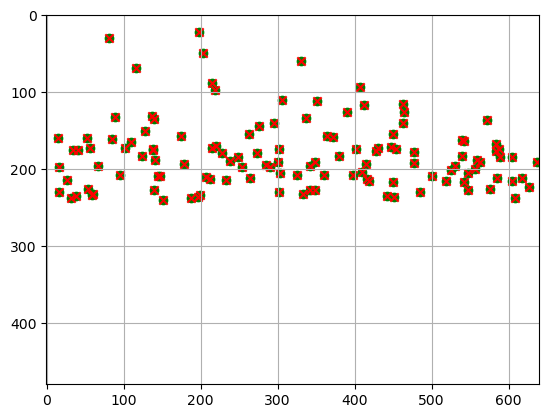

In [6]:
index = 1

data = vo.get_data()
camera = vo.get_camera()
trajectory = vo.get_trajectory()[index]

camera.set_c_T_w(np.linalg.inv(trajectory))

measurement = data.get_measurements_data_points(index)

# matches = data_association_2Dto3D(measurement, vo.get_map(), camera)
matches = data_association_on_appearance(measurement, vo.get_map())

image_points = matches['points_1']
world_points = matches['points_2']

projected_world_points = []
for i in range(len(world_points)):
    world_point = world_points[i]
    is_inside, projected_image_point = camera.project_point(world_point)
    if is_inside: projected_world_points.append(projected_image_point)

fig, ax = plt.subplots()
ax.imshow(np.ones((480, 640, 3)))
ax.scatter([point[0] for point in image_points], [point[1] for point in image_points], color='green', marker='o')
ax.scatter([point[0] for point in projected_world_points], [point[1] for point in projected_world_points], color='red', marker='x')
plt.grid()
plt.show()

In [7]:
world_points = vo.get_map()['position']
print('Number of world points: ', len(world_points))

x_coords = [point[0] for point in world_points]
y_coords = [point[1] for point in world_points]
z_coords = [point[2] for point in world_points]

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=2)))
fig.show()

Number of world points:  250


In [8]:
gt_world_data = data.get_world_data()
triangulated_points = vo.get_map()

matches = data_association_on_appearance(triangulated_points, gt_world_data)
triangulated_points = matches['points_1']
gt_world_points = matches['points_2']

for i in range(len(triangulated_points)):
    point_1 = matches['points_1'][i]
    point_1 = camera.get_camera_transform() @ np.append(point_1, 1)
    point_1 = point_1[:3] / point_1[3]
    point_2 = matches['points_2'][i]

    distance = np.linalg.norm(point_1 - point_2)
    print(f'Distance between point {i}: {np.round(distance, 2)}')


triangulated_points_hom = [np.append(point, 1) for point in triangulated_points]
triangulated_points_world = camera.get_camera_transform() @ np.array(triangulated_points_hom).T


x_coords = [point[0]*0.205 for point in triangulated_points_world.T]  
y_coords = [point[1]*0.205 for point in triangulated_points_world.T]
z_coords = [point[2]*0.205 for point in triangulated_points_world.T]

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=4)))

x_coords_gt = [point[0] for point in gt_world_points]
y_coords_gt = [point[1] for point in gt_world_points]
z_coords_gt = [point[2] for point in gt_world_points]

fig.add_trace(go.Scatter3d(x=x_coords_gt, y=y_coords_gt, z=z_coords_gt, mode='markers', marker=dict(size=2, color='red')))

fig.show()

Distance between point 0: 15.87
Distance between point 1: 7.34
Distance between point 2: 33.4
Distance between point 3: 13.58
Distance between point 4: 26.44
Distance between point 5: 14.31
Distance between point 6: 19.75
Distance between point 7: 16.22
Distance between point 8: 13.75
Distance between point 9: 20.22
Distance between point 10: 25.65
Distance between point 11: 28.28
Distance between point 12: 12.26
Distance between point 13: 22.06
Distance between point 14: 30.72
Distance between point 15: 13.21
Distance between point 16: 31.05
Distance between point 17: 21.51
Distance between point 18: 22.24
Distance between point 19: 25.91
Distance between point 20: 9.38
Distance between point 21: 12.5
Distance between point 22: 21.01
Distance between point 23: 13.64
Distance between point 24: 22.44
Distance between point 25: 33.93
Distance between point 26: 10.67
Distance between point 27: 25.06
Distance between point 28: 13.99
Distance between point 29: 29.98
Distance between point 3